In [1]:
# Install new dependencies (Run this line once!!)

import sys
# !{sys.executable} -m pip install scipy

In [2]:
%matplotlib notebook

import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Import dependencies and set random seed
seed_value = 5
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

import sys
import os
sys.path.insert(0, os.path.abspath('Support'))

from path_search import *

# PRM Algorithm

The class below shows a possible implementation of the PRM planning algorithm. The main methods are:

- ``generate_samples(.)``, this method uniformly generates N points in the collision-free space. The sampled points define the vertices in the roadmap

- ``define_edges(.)``, this method connects two vertices if the line segment that passes through them lies in the collision-free space and has length less or equal than D.

- ``is_there_collision(.)``, this method determines whether the edge connecting two vertices is in the collision-free space

- ``__generate_roadmap__(.)``, this is the main algorithm. It generates the roadmap that will be later used to search for path connecting two points

- ``plan(.)``, this is method searches for a path in the road map that connects a start and a goal locations. Currently we have implemented a breadth_first_search, but other graph-based search algorithms could alse be used

**TODO**:
- Complete the ``is_there_collision(.)`` method. 

*Hint: Use the ``self.obstacles.query([x,y])`` method to compute the distance between a point $(x,y)$ and all obstacles close to it, ``return True`` if distance to obstacle is less than robot radius*

In [3]:
# This code is partly based in the implementation done by Atsushi Sakai (@Atsushi_twi)

class Roadmap:
    
    def __init__(self, obstacle_x, obstacle_y):
        
        # We use a kdtree structure to speed up nearest-neighbour lookup
        self.obstacles = cKDTree(np.vstack((ox, oy)).T)
        self.width = np.max(np.array(ox))
        self.height = np.max(np.array(oy))
        
        # These two variables define our roadmap
        self.vertices = []
        self.edges = []
        
        self.is_built = False
        
        
    def generate_samples(self, num_samples=100, robot_radius=5):
        
        sample_x, sample_y = [], []
        
        while len(sample_x) < num_samples:
            p_x = self.width * np.random.random_sample()
            p_y = self.height * np.random.random_sample()
            
            # Check if new point is in free space.
            # We use a kdtree to look for obstacle close to (p_x, p_y)
            # If distance between p_x, p_y and obstacle is less than robot radius, new point is considered
            # to be outside of free space and it is discarded from sample
            
            dist, index = self.obstacles.query([p_x, p_y])

            if dist >= robot_radius:
                sample_x.append(p_x)
                sample_y.append(p_y)

        
        self.vertices = np.vstack((sample_x, sample_y)).T
     
    
    def define_edges(self, robot_radius=5, distance_threshold=10.0, num_neighbors=10):
        """
        Road map generation
        - Two points are neighbours if their distance is less than distance_threshold
        - Neighborhood set size is limited by num_neighbours
        - Two vertices are connected if the line segment that connects them lies in the
          free space and has length <= distance_threshold
        """

        n_vertices = self.vertices.shape[0]
        
        # We use again a kdtree to speed neighbours search
        sample_kd_tree = cKDTree(self.vertices)

        for v_x, v_y in self.vertices:
            _, indexes = sample_kd_tree.query([v_x, v_y], k=num_neighbors, distance_upper_bound=distance_threshold)
            edge_id = []

            for i in range(1, len(indexes)):
                idx = indexes[i]
                
                # Kdtree returns invalid index if there is less than k neighbors
                
                if idx < self.vertices.shape[0]:
                    n_x, n_y = self.vertices[idx,:]

                    if not self.is_there_collision(v_x, v_y, n_x, n_y, robot_radius):
                        edge_id.append(idx)

            self.edges.append(edge_id)

    
    def build_roadmap_and_plot(self, num_samples=100, max_distance=10, max_neighbours=10, robot_size=2.5):
        
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                             xlim=(-10, 70), ylim=(-10, 70))
        plt.grid(True)
        
        obs = self.obstacles.data
        ax.plot(obs[:,0], obs[:,1], ".k")
        
        self.__generate_roadmap__(num_samples, max_distance, max_neighbours, robot_size)
        
        for i, v_edges in enumerate(self.edges):
            for e_idx in v_edges:
                v_from = self.vertices[i,:]
                v_to = self.vertices[e_idx,:]
                
                ax.plot([v_from[0], v_to[0]],
                        [v_from[1], v_to[1]], "k--", lw=0.5)
                
        return fig, ax


    def is_there_collision(self, s_x, s_y, g_x, g_y, robot_radius):
        """
        To detect if an edge connecting two vertices is in collision with any obstacle, we consider 
        the following collision check algorithm:
        - Connect the two vertices with a line segment
        - Select a set of intermidiate points pN strictly inside the segment
          and check that distance between each p in pN and obstacles is less than robot size
        - If so, there is no enough space for the robot and return True
        
        """
        
        x = s_x
        y = s_y
        dx = g_x - s_x
        dy = g_y - s_y
        yaw = math.atan2(dy, dx)
        yaw_cos, yaw_sin = np.cos(yaw), np.sin(yaw)
        segment_length = math.hypot(dx, dy)

        step_size = robot_radius
        n_step = int(np.round(segment_length / step_size))
                        
        for i in range(n_step):

            # -----------TO DO: Check for collision with obstacle for intermidiate point (x,y)---------
           
            # Hint: Use the self.obstacles.query([x,y]) kdtree to compute the distance between (x,y) 
            # and all obstacle points close to it.
            # return True if distance to obstacle is less than robot_radius
            
            dist, index = self. obstacles. query([x, y])
            if dist < robot_radius: 
                return True
            # ------------------------------------------------------------------------------------------
        
            # Compute next intermidiate point in segment
            x += step_size * yaw_cos
            y += step_size * yaw_sin
            

        return False  # Edge is collision free
    
    def __generate_roadmap__(self, num_samples=100, max_distance=10, max_neighbours=10, robot_size=2.5):
        if not self.is_built:
            # Generate sample points in free space (these are the vertices in the roadmap)
            self.generate_samples(num_samples=num_samples, robot_radius=robot_size)
        
            # Connect vertices using simple planner. Planner checks if edge between two vertices
            # is in collision with obstacle. If edge is collision-free, we add it to the roadmap
            self.define_edges(robot_radius=robot_size, distance_threshold=max_distance, 
                              num_neighbors=max_neighbours)
            
            self.is_built = True

    def plan(self, start, goal):
        
        # Generate roadmap if needed
        self.__generate_roadmap__()
        
        # Apply a graph search algorithm to find path connecting start and goal
        path = breadth_first_search(self, start, goal)        
        
        if path is None:
            print("There is no path")
        
        return path
        

## Build a PRM

Here we build our probabilistic road map. 

**Interaction**:
- Change the values of the parameters ``num_samples, max_distance, max_neighbours`` and see how the roadmap changes. 

*Reminder*: ``num_samples`` indicates how many vertices we want in the map, ``max_distance`` defines the maximum length of an edge, and ``max_neighbours`` tells us how many neighboring vertices are considered when creating edges for a vertex v

<IPython.core.display.Javascript object>


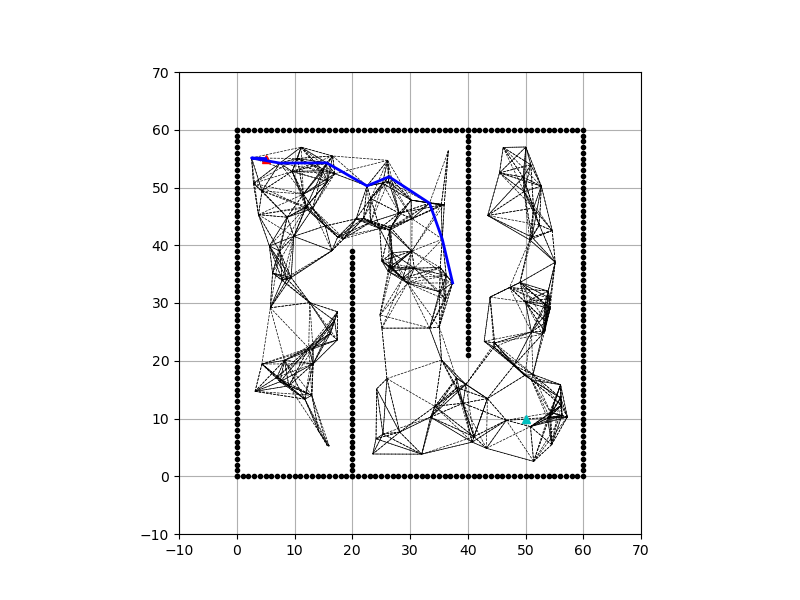

In [12]:
ox = []
oy = []

for i in range(60):
    ox.append(i)
    oy.append(0.0)
for i in range(60):
    ox.append(60.0)
    oy.append(i)
for i in range(61):
    ox.append(i)
    oy.append(60.0)
for i in range(61):
    ox.append(0.0)
    oy.append(i)
for i in range(40):
    ox.append(20.0)
    oy.append(i)
for i in range(40):
    ox.append(40.0)
    oy.append(60.0 - i)

    
# Create roadmap object and generate map
rmap = Roadmap(ox, oy)
fig, ax = rmap.build_roadmap_and_plot(num_samples=150, robot_size=2.5, max_distance=10, max_neighbours=10)

## PRM in Execution

Let's see the PRM algorithm in execution. Unless not fully connected, the same roadmap can be used to find a path that connects 2 points in the collision-free space.


**Interaction**:
- Define different start and goal locations. Observe the paths generated for all cases (**click on the figure if you don't see an animation**).

In [13]:
# Define a start and goal location and search for path
# start = np.array([10, 10])
# goal = np.array([50, 50])

start = np.array([5, 55])
goal = np.array([50, 10])

# start = np.array([10, 10])
# goal = np.array([30, 10])

path = rmap.plan(start, goal)

# Animation code
start_plot, = ax.plot([], [], "^r", lw=5)
goal_plot, = ax.plot([], [], "^c", lw=5)
line_path, = ax.plot([], [], "b", lw=2)    

if path:
    path_in_order = np.flipud(path)
    start_pos = path_in_order[0,:]
            
    def init():
        print(init)
        start_plot.set_data(start[0], start[1])
        goal_plot.set_data(goal[0], goal[1])
        line_path.set_data([], [])
        return line_path, start_plot, goal_plot

    def animate(i):
        """perform animation step"""
        line_path.set_data(path_in_order[:i,0], path_in_order[:i, 1])
        return line_path

    ani = animation.FuncAnimation(fig, animate, frames=30, blit=True, interval=30, init_func=init)

**FLUX Question (1 pt)**: What is the main parameter (``num_samples, max_distance``, or ``max_neighbours``) we should modify in the case that a path between 2 points is not found because the roadmap is not fully connected?